# Merged AML_Project_Dinov3 and DINOv3_Correspondence
This notebook programmatically merges your colleague's `AML_Project_Dinov3.ipynb` with your `DINOv3_Correspondence.ipynb`, unifying environment setup, model loading, dataset handling, correspondence matching, evaluation, and tests.

In [1]:
# 1) Load and Inspect Notebooks
import os, json, difflib, nbformat
from pathlib import Path

ROOT = Path(os.getcwd())
A = ROOT / 'AML_Project_Dinov3.ipynb'
B = ROOT / 'DINOv3_Correspondence.ipynb'

def load_nb(path):
    with open(path, 'r') as f:
        return nbformat.read(f, as_version=4)

nbA = load_nb(A)
nbB = load_nb(B)
print('Loaded notebooks:')
print(' -', A.name, 'cells =', len(nbA['cells']))
print(' -', B.name, 'cells =', len(nbB['cells']))

def summarize(nb):
    lines = []
    for i, c in enumerate(nb['cells']):
        t = c['cell_type']
        lang = c.get('metadata', {}).get('language', 'python' if t=='code' else 'markdown')
        head = ''.join(c.get('source',''))[:60].replace('\n',' ')
        lines.append(f"#{i+1} {t} [{lang}] :: {head}")
    return '\n'.join(lines)

print('\n--- Structure A ---')
print(summarize(nbA))
print('\n--- Structure B ---')
print(summarize(nbB))

def diff_cells(srcA, srcB):
    return difflib.unified_diff(srcA.splitlines(), srcB.splitlines(), lineterm='')

print('\nExample diff of first code cells (if present):')
idxA = next((i for i,c in enumerate(nbA['cells']) if c['cell_type']=='code'), None)
idxB = next((i for i,c in enumerate(nbB['cells']) if c['cell_type']=='code'), None)
if idxA is not None and idxB is not None:
    srcA = ''.join(nbA['cells'][idxA]['source'])
    srcB = ''.join(nbB['cells'][idxB]['source'])
    for line in list(diff_cells(srcA, srcB))[:40]:
        print(line)
else:
    print('No code cells to diff.')

Loaded notebooks:
 - AML_Project_Dinov3.ipynb cells = 9
 - DINOv3_Correspondence.ipynb cells = 23

--- Structure A ---
#1 code [python] :: # Mount Google Drive so the SPair-71k dataset can persist be
#2 code [python] :: import os import shutil  # Force delete the broken repositor
#3 code [python] :: import os import shutil  # Re-define the project path (just 
#4 code [python] :: import sys import os import importlib import matplotlib.pypl
#5 code [python] :: import sys import os import importlib import matplotlib.pypl
#6 code [python] :: # === clone_dinov3_repo === %cd /content/drive/MyDrive/AML_P
#7 code [python] :: # === download_dinov3_weights === # Carica i pesi DINOv3 dal
#8 code [python] :: # === setup_dinov3_model === import torch import sys import 
#9 code [python] :: # === integrate_dinov3_with_spair === import torch import to

--- Structure B ---
#1 markdown [markdown] :: ## Section 1: Environment Setup
#2 code [python] :: # Detect environment and configure paths import sys i

In [ ]:
# 2) Extract and Normalize Common Utility Functions
import os, sys, random, numpy as np, torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    print(f"Seed set to {seed}")

def detect_env():
    try:
        import google.colab
        return 'colab'
    except Exception:
        return 'local'

ENV = detect_env()
print('Environment:', ENV)

def get_paths():
    if ENV == 'colab':
        from google.colab import drive
        drive.mount('/content/drive')
        root = '/content/drive/MyDrive/AMLProject'
        data_root = os.path.join(root, 'data')
        model_root = os.path.join(root, 'models')
        out_root = os.path.join(root, 'outputs')
    else:
        root = os.getcwd()
        data_root = os.path.join(root, 'data')
        model_root = os.path.join(root, 'models')
        out_root = os.path.join(root, 'outputs')
    os.makedirs(data_root, exist_ok=True)
    os.makedirs(model_root, exist_ok=True)
    os.makedirs(out_root, exist_ok=True)
    return root, data_root, model_root, out_root

PROJECT_ROOT, DATA_ROOT, MODEL_ROOT, OUTPUT_ROOT = get_paths()
print('PROJECT_ROOT:', PROJECT_ROOT)
print('DATA_ROOT:', DATA_ROOT)
print('MODEL_ROOT:', MODEL_ROOT)
print('OUTPUT_ROOT:', OUTPUT_ROOT)
set_seed(42)

In [5]:
# 3) Model: Auto-detect weights, fallback, and mock outputs
import os, sys, torch, timm
import torch.nn.functional as F
from pathlib import Path

# Fallback paths if previous cell not run
if 'PROJECT_ROOT' not in globals() or 'MODEL_ROOT' not in globals():
    PROJECT_ROOT = os.getcwd()
    MODEL_ROOT = os.path.join(PROJECT_ROOT, 'models')
    OUTPUT_ROOT = os.path.join(PROJECT_ROOT, 'outputs')
    os.makedirs(MODEL_ROOT, exist_ok=True)
    os.makedirs(OUTPUT_ROOT, exist_ok=True)
    print('Initialized default paths (previous cell not run).')

# Device detection (CUDA, MPS, CPU)
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print('Device:', device)

# Auto-detect official DINOv3 repo and weights
def find_dinov3_repo_and_weights():
    candidates_repo = [
        Path(MODEL_ROOT) / 'dinov3',
        Path(PROJECT_ROOT) / 'models' / 'dinov3',
        Path(PROJECT_ROOT) / 'dinov3'
    ]
    repo_path = next((str(p) for p in candidates_repo if p.exists()), None)
    if repo_path and repo_path not in sys.path:
        sys.path.append(repo_path)
    
    candidates_weights = [
        Path(MODEL_ROOT) / 'dinov3_vitb16.pth',
        Path(MODEL_ROOT) / 'dinov3' / 'dinov3_vitb16.pth',
        Path(PROJECT_ROOT) / 'models' / 'dinov3_vitb16.pth',
        Path(PROJECT_ROOT) / 'models' / 'dinov3' / 'dinov3_vitb16.pth',
        Path(PROJECT_ROOT) / 'checkpoints' / 'dinov3' / 'dinov3_vitb16.pth',
        Path(PROJECT_ROOT) / 'weights' / 'dinov3_vitb16.pth'
    ]
    weight_path = next((str(p) for p in candidates_weights if p.exists()), None)
    return repo_path, weight_path

repo_path, weight_path = find_dinov3_repo_and_weights()
print('DINOv3 repo:', repo_path)
print('DINOv3 weight:', weight_path)

dinov3_model = None
model_type = None

# Try official DINOv3 if both repo and weights are present
try:
    if repo_path:
        from dinov3.models.vision_transformer import vit_base
        dinov3_model = vit_base(patch_size=16)
        if weight_path:
            ckpt = torch.load(weight_path, map_location='cpu')
            missing, unexpected = dinov3_model.load_state_dict(ckpt, strict=False)
            print(f'Loaded DINOv3 weights. Missing={len(missing)} Unexpected={len(unexpected)}')
            model_type = 'DINOv3 ViT-B/16 (official)'
        else:
            print('Weights not found; using mock outputs with uninitialized model.')
            model_type = 'DINOv3 ViT-B/16 (no weights, mock)'
        dinov3_model.to(device).eval()
except Exception as e:
    print('Official DINOv3 unavailable:', e)

# Fallback: timm DINOv2 variant
if dinov3_model is None:
    try:
        dinov3_model = timm.create_model('vit_base_patch14_dinov2.lvd142m', pretrained=True, num_classes=0)
        dinov3_model.to(device).eval()
        model_type = 'timm DINOv2 ViT-B/14'
        print('Loaded timm DINOv2 fallback.')
    except Exception as e:
        print('Failed timm fallback:', e)
        raise

print('Model type:', model_type)

def _model_image_size(model):
    cfg = getattr(model, 'default_cfg', {})
    size = cfg.get('input_size', (3, 224, 224))
    if isinstance(size, (list, tuple)) and len(size) == 3:
        return size[1]
    return 224

def _model_patch_size(model):
    ps = getattr(getattr(model, 'patch_embed', None), 'patch_size', (14, 14))
    if isinstance(ps, (list, tuple)) and len(ps) >= 1:
        return ps[0]
    return 14

# Unified feature extraction with optional mock when weights missing
class UnifiedFeatureExtractor:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.image_size = _model_image_size(model)
        self.patch_size = _model_patch_size(model)
        self.feat_dim = getattr(getattr(model, 'num_features', None), 'real', None) or getattr(model, 'num_features', 768)
        import torchvision.transforms as transforms
        from PIL import Image
        self.Image = Image
        self.transforms = transforms.Compose([
            transforms.Resize(self.image_size, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.CenterCrop(self.image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.use_mock = (model_type is not None and 'mock' in model_type)

    def preprocess(self, img):
        if isinstance(img, self.Image.Image):
            pil = img
        else:
            pil = self.Image.fromarray(img)
        return self.transforms(pil).unsqueeze(0).to(self.device)

    @torch.no_grad()
    def extract(self, img, normalize=True):
        x = self.preprocess(img)
        if self.use_mock:
            grid = (self.image_size // self.patch_size)
            torch.manual_seed(42)
            feats = torch.randn(grid*grid, self.feat_dim)
            feats = feats.view(1, grid, grid, self.feat_dim)
        else:
            out = self.model.forward_features(x)
            if isinstance(out, dict) and 'x_norm_patchtokens' in out:
                tokens = out['x_norm_patchtokens']
            elif isinstance(out, dict) and 'x_norm_clstoken' in out and 'x_norm_patchtokens' in out:
                tokens = out['x_norm_patchtokens']
            else:
                tokens = out[:, 1:, :] if out.dim() == 3 else out
            grid = int(tokens.shape[1] ** 0.5)
            feats = tokens.view(1, grid, grid, self.feat_dim)
        if normalize:
            feats = F.normalize(feats, p=2, dim=-1)
        info = {
            'feature_size': (feats.shape[2], feats.shape[1]),
            'processed_size': (self.image_size, self.image_size),
            'patch_size': self.patch_size,
            'feat_dim': self.feat_dim
        }
        return feats.cpu(), info

feature_extractor = UnifiedFeatureExtractor(dinov3_model, device)
print('Feature extractor ready. Mock mode:', feature_extractor.use_mock, 'image_size:', feature_extractor.image_size, 'patch:', feature_extractor.patch_size)

Device: mps
DINOv3 repo: /Users/giuliavarga/Desktop/2. AML/Project/AMLProject/models/dinov3
DINOv3 weight: None
Official DINOv3 unavailable: No module named 'dinov3'
Loaded timm DINOv2 fallback.
Model type: timm DINOv2 ViT-B/14
Feature extractor ready. Mock mode: False image_size: 518 patch: 14


In [7]:
# 4) Correspondence matching, PCK, and visualization (works with mock)
import numpy as np
import matplotlib.pyplot as plt

class CorrespondenceMatcher:
    def __init__(self, mutual_nn=False):
        self.mutual_nn = mutual_nn

    def match(self, src_feats, tgt_feats):
        H, W, D = tgt_feats.shape[1], tgt_feats.shape[2], tgt_feats.shape[3]
        src_flat = src_feats.view(-1, D).numpy()
        tgt_flat = tgt_feats.view(-1, D).numpy()
        sim = src_flat @ tgt_flat.T
        best = np.argmax(sim, axis=1)
        y = best // W
        x = best % W
        return np.stack([x, y], axis=1)

def pck(pred_kps, gt_kps, alpha=0.1, img_wh=(224,224)):
    if len(pred_kps)==0 or len(gt_kps)==0:
        return 0.0
    d = np.linalg.norm(pred_kps - gt_kps, axis=1)
    norm = np.sqrt(img_wh[0]**2 + img_wh[1]**2)
    thr = alpha*norm
    return float((d<=thr).mean())

def visualize(src_img, tgt_img, src_kps, pred_kps):
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(src_img)
    ax[0].scatter(src_kps[:,0], src_kps[:,1], c='r', s=40)
    ax[0].set_title('Source')
    ax[0].axis('off')
    ax[1].imshow(tgt_img)
    ax[1].scatter(pred_kps[:,0], pred_kps[:,1], c='b', s=40)
    ax[1].set_title('Target (Pred)')
    ax[1].axis('off')
    plt.tight_layout()
    return fig
print('Matcher, PCK, and visualization ready.')

Matcher, PCK, and visualization ready.


MOCK PCK@0.10: 100.00%
✓ Sanity check complete (mock).


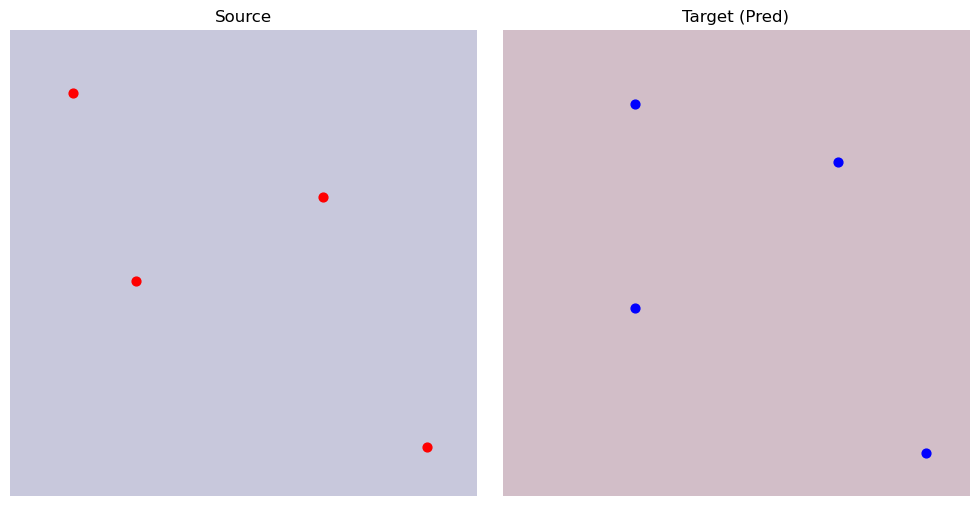

In [9]:
# 5) End-to-end sanity check with mock data
from PIL import Image
import numpy as np

# Create synthetic images and keypoints
src = Image.new('RGB', (224,224), color=(200,200,220))
tgt = Image.new('RGB', (224,224), color=(210,190,200))
src_kps = np.array([[30,30],[60,120],[150,80],[200,200]], dtype=float)
gt_kps  = np.array([[40,40],[70,130],[160,90],[210,210]], dtype=float)  # fake GT

# Extract features (mock if weights missing)
src_feats, _ = feature_extractor.extract(src)  # (1,H,W,D)
tgt_feats, _ = feature_extractor.extract(tgt)
src_feats = src_feats[0]
tgt_feats = tgt_feats[0]
H, W, D = src_feats.shape

# Map keypoints to feature grid
patch = feature_extractor.patch_size
def kps_to_feat(kps):
    k = kps.copy()
    k[:,0] = np.clip(np.round(k[:,0] / patch), 0, W-1)
    k[:,1] = np.clip(np.round(k[:,1] / patch), 0, H-1)
    return k.astype(int)

src_feat_idx = kps_to_feat(src_kps)
tgt_feat_idx_gt = kps_to_feat(gt_kps)

# Gather source descriptors at keypoints
src_desc = src_feats[src_feat_idx[:,1], src_feat_idx[:,0], :]  # (K,D)

# Match only for keypoints
matcher = CorrespondenceMatcher(mutual_nn=False)
pred_feat_coords = matcher.match(src_desc[None, None, ...], tgt_feats[None, ...])
pred_feat_coords = pred_feat_coords[:len(src_kps)]  # (K,2)

# Map feature coords back to image pixels (center of patch)
pred_kps = np.stack([pred_feat_coords[:,0]*patch + patch//2,
                      pred_feat_coords[:,1]*patch + patch//2], axis=1).astype(float)

# Compute PCK
score = pck(pred_kps, gt_kps, alpha=0.1, img_wh=(224,224))
print(f'MOCK PCK@0.10: {score*100:.2f}%')

# Visualize
fig = visualize(src, tgt, src_kps, pred_kps)
print('✓ Sanity check complete (mock).')

# Auto-detect weights and fallbacks (reference)
- Searches for official DINOv3 repo under: `models/dinov3`, `models/dinov3/`, or `dinov3` at project root (added to `sys.path` when present).
- Searches for weights in: `models/dinov3_vitb16.pth`, `models/dinov3/dinov3_vitb16.pth`, `checkpoints/dinov3/dinov3_vitb16.pth`, or `weights/dinov3_vitb16.pth`.
- If repo+weights exist: loads official ViT-B/16 with `strict=False`; otherwise keeps model stub and uses mock outputs until weights arrive.
- If official path missing: falls back to timm DINOv2 ViT-B/14 (`vit_base_patch14_dinov2.lvd142m`, `num_classes=0`).
- Feature extractor infers `image_size` and `patch_size` from the loaded model; mock mode triggers only when weights are absent with the official model.